In [39]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
def awgn(iq, scale):
    r =  iq
    # r = np.copy(iq)
    r.real += np.random.normal(scale=scale, size=iq.shape)
    r.imag += np.random.normal(scale=scale, size=iq.shape)
    return r
    
    
def snr(pure, noisy):
    sig_pow = np.nanmean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.nanmean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

def postprocess(x):
    pyh = x
    pyh = pyh[bit_reversed_indexes(fft_size)]
    pyh = np.fft.fftshift(pyh)
    pyh = [complex(x) for x in pyh]
#     pyh = np.abs(pyh)
    pyh = pyh * np.conjugate(pyh)
#     pyh = pyh / pyh.max()
    return pyh.real

    a = 20 * np.log10(pyh 
#                       + 0.0000000000000000000001
                     ) # add small number to avoid div by 0
    return a


from pyha import Hardware, simulate, sims_close, Complex, Sfix, scalb

results = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
fft_size = 1024

# sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100) * 0.25
# sig = sig * hann_fix9

# sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 110) * 0.25
# sig2 = sig2 * hann_fix9

# sig = sig + sig2

sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 1000) * 1 / 2 / 2
# sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 500) /2 /2
# sig = sig + sig2
# for i in range(800, 1000, 2):
#     sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i * -1)
#     sig = sig + sig2

# sig = awgn(sig, 0.01)
    
# sig *= 1 / 2 / 2 / 2 /2 / 2 / 2 / 2 / 2 / 2 /2 /2 /2 /2 /2 / 2 /2 /2 /2
# sig *= 1 / 2 / 2 / 2 /2 / 2 / 2 /2 /2 /2
# sig *= 1 / 2 / 2 /2 /2 /2 /2/2/2/2/2

# sig = np.array([Complex(x, 0, -11, overflow_style='saturate').val for x in  sig]) # simulate ADC
sig *= np.hanning(fft_size)
# sig_fix *= hann_fix9

/usr/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


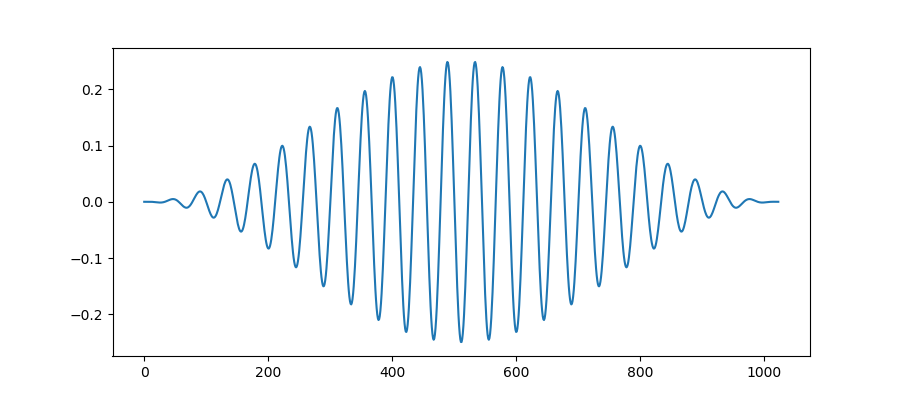

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


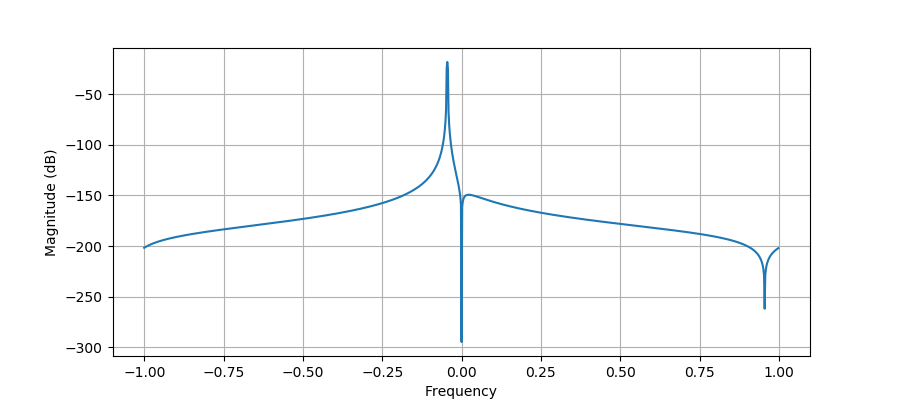

In [41]:
plt.plot(sig)
plt.show()

plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

In [36]:
dut = R2SDF(fft_size, twiddle_bits=12)
sims = simulate(dut, sig, input_types=[Complex(0,0,-17)], simulations=['MODEL', 'PYHA'], output_callback=unpackage, input_callback=package)
results['PYHA'] = postprocess(np.array([complex(x) for x in sims['PYHA'][0]]))
results['MODEL'] = postprocess(np.array([complex(x) for x in sims['MODEL'][0]]))


INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 2048/2048 [00:02<00:00, 689.06it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


<IPython.core.display.Javascript object>


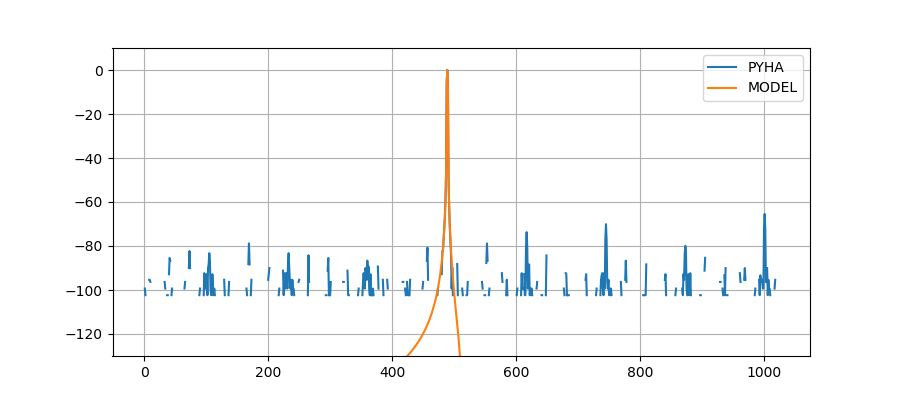

In [37]:
for key, val in results.items():
    plt.plot(10 * np.log10(val), label=key)
plt.legend()
plt.ylim([-130, 10])
plt.grid()
plt.show()

In [38]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=f'{key} - {snr(results["Float64"], val)} SNR')
plt.legend()
plt.grid()
plt.show()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)

KeyError: 'Float64'